<a href="https://colab.research.google.com/github/eriosta/neuro/blob/main/Hierarchical_Clustering_of_Spatial_Correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q nilearn
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets
from nilearn.decomposition import DictLearning
from nilearn import plotting, image
from scipy.stats import pearsonr
from nilearn import datasets, image
from nilearn.decomposition import DictLearning
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 35.0 MB/s eta 0:00:00


## No Clustering


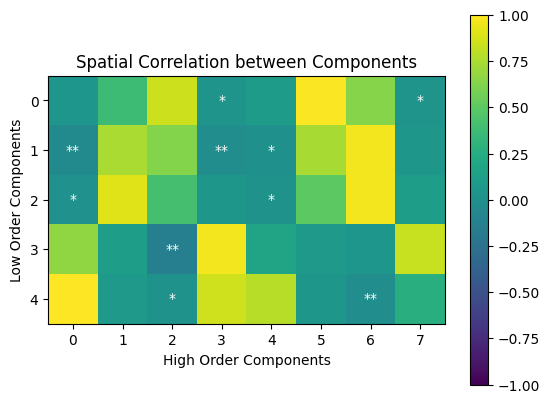

In [ ]:
# Choose how many subjects to get (e.g., 1 subject)
n_subjects = 1

# Fetch the ADHD200 resting-state fMRI dataset
adhd_dataset = datasets.fetch_adhd(n_subjects=n_subjects)
func_filenames = adhd_dataset.func

# Decomposition into 5 components
dict_learn_5 = DictLearning(n_components=5, random_state=0, memory="nilearn_cache", memory_level=2)
components_img_5 = dict_learn_5.fit_transform(func_filenames)
# Decomposition into 8 components
dict_learn_8 = DictLearning(n_components=8, random_state=0, memory="nilearn_cache", memory_level=2)
components_img_8 = dict_learn_8.fit_transform(func_filenames)

# Initialize correlation matrix
correlation_matrix = np.zeros((5, 8))

for i in range(5):
    for j in range(8):
        # Extract data arrays
        data_5 = components_img_5[0][..., i]
        data_8 = components_img_8[0][..., j]

        # Compute the spatial correlation between the two components
        correlation = np.corrcoef(data_5.ravel(), data_8.ravel())[0, 1]

        correlation_matrix[i, j] = correlation

# Visualize the correlation matrix using a heatmap with annotations
plt.imshow(correlation_matrix, cmap='viridis', vmin=-1, vmax=1)

for i in range(5):
    for j in range(8):
        if correlation_matrix[i, j] < 0.001:
            plt.text(j, i, f'**', ha='center', va='center', color='white')
        elif correlation_matrix[i, j] < 0.05:
            plt.text(j, i, f'*', ha='center', va='center', color='white')
        else:
            plt.text(j, i, f'', ha='center', va='center', color='black')

plt.colorbar()
plt.xlabel("High Order Components")
plt.ylabel("Low Order Components")
plt.title("Spatial Correlation between Components")
plt.show()


## Hierarchical Clustering, Pearson

Enter the number of low-order components: 20
Enter the number of high-order components: 100


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:739: FutureWarning: 'n_iter' is deprecated in version 1.1 and will be removed in version 1.3. Use 'max_iter' instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


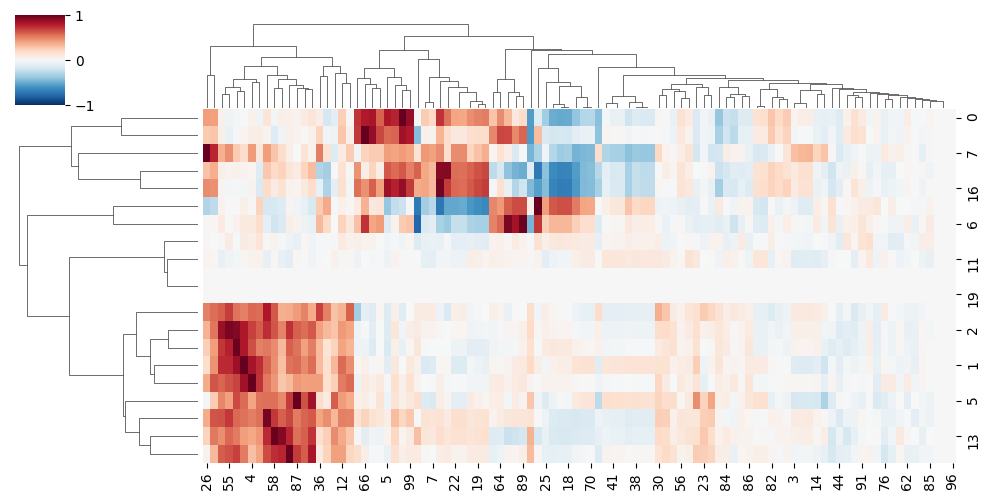

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets
from nilearn.decomposition import DictLearning
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import seaborn as sns
from scipy.stats import pearsonr
import pandas as pd

class ComponentCorrelationVisualizer:
    def __init__(self, n_low_order, n_high_order):
        self.n_low_order = n_low_order
        self.n_high_order = n_high_order

    def fetch_data(self):
        n_subjects = 1
        adhd_dataset = datasets.fetch_adhd(n_subjects=n_subjects)
        self.func_filenames = adhd_dataset.func

    def perform_decomposition(self):
        dict_learn_low = DictLearning(n_components=self.n_low_order, random_state=0, memory="nilearn_cache", memory_level=2)
        self.components_img_low = dict_learn_low.fit_transform(self.func_filenames)

        dict_learn_high = DictLearning(n_components=self.n_high_order, random_state=0, memory="nilearn_cache", memory_level=2)
        self.components_img_high = dict_learn_high.fit_transform(self.func_filenames)

    def compute_correlation_matrix(self):
        self.correlation_matrix = np.zeros((self.n_low_order, self.n_high_order))
        self.p_values = np.ones((self.n_low_order, self.n_high_order))

        self.results = []

        for i in range(self.n_low_order):
            for j in range(self.n_high_order):
                data_low = self.components_img_low[0][..., i]
                data_high = self.components_img_high[0][..., j]
                correlation, p_value = pearsonr(data_low.ravel(), data_high.ravel())
                self.correlation_matrix[i, j] = correlation
                self.p_values[i, j] = p_value

                self.results.append({
                    'Low_Order_Component': i,
                    'High_Order_Component': j,
                    'Pearson_r': correlation,
                    'p_value': p_value
                })

        # Replace NaN or inf values in the correlation matrix with 0
        self.correlation_matrix = np.nan_to_num(self.correlation_matrix, nan=0.0, posinf=0.0, neginf=0.0)

    def export_results_to_csv(self, filename="correlation_results.csv"):
        df = pd.DataFrame(self.results)

        # Sort by p_value in ascending order
        df = df.sort_values(by='p_value')

        df.to_csv(filename, index=False)

    def plot_heatmap(self):
        # Use a diverging colormap that transitions from red to blue
        diverging_cmap = plt.cm.RdBu_r

        # Plotting hierarchical clustering heatmap with the diverging colormap
        figsize = (10, 5)
        g = sns.clustermap(
            self.correlation_matrix,
            method="average",
            cmap=diverging_cmap,
            vmin=-1,
            vmax=1,
            annot=False,
            fmt=".2f",
            figsize=figsize,
        )

    # # TO-DO: Consider interactive plot:
    # import plotly.express as px
    # def plot_heatmap(self):
    #     # Create a DataFrame for plotly heatmap
    #     df = pd.DataFrame(self.results)

    #     fig = px.imshow(
    #         self.correlation_matrix,
    #         labels=dict(x="High Order Component", y="Low Order Component", color="Correlation"),
    #         x=df['High_Order_Component'].unique(),
    #         y=df['Low_Order_Component'].unique(),
    #         color_continuous_scale="RdBu_r",
    #         range_color=[-1, 1],
    #         title="Correlation Heatmap",
    #         hover_data={
    #             "Pearson_r": ':.2f',
    #             "p_value": ':.5f'
    #         }
    #     )

    #     fig.show()

    def visualize_component_correlation(self):
        self.fetch_data()
        self.perform_decomposition()
        self.compute_correlation_matrix()
        self.plot_heatmap()
        self.export_results_to_csv()

if __name__ == "__main__":
    n_low_order = int(input("Enter the number of low-order components: "))
    n_high_order = int(input("Enter the number of high-order components: "))
    visualizer = ComponentCorrelationVisualizer(n_low_order, n_high_order)
    visualizer.visualize_component_correlation()


## Hierarchical Clustering, Sparse Inverse Covariance

In [17]:
# import numpy as np
# import matplotlib.pyplot as plt
# from nilearn import datasets
# from nilearn.decomposition import DictLearning
# from nilearn.input_data import NiftiMapsMasker
# import seaborn as sns
# from sklearn.covariance import GraphicalLassoCV
# from numpy.linalg import norm

# class ComponentCorrelationVisualizer:
#     def __init__(self, n_low_order, n_high_order):
#         self.n_low_order = n_low_order
#         self.n_high_order = n_high_order

#     def fetch_data(self):
#         n_subjects = 1
#         adhd_dataset = datasets.fetch_adhd(n_subjects=n_subjects)
#         self.func_filenames = adhd_dataset.func

#     def perform_decomposition(self):
#         dict_learn_low = DictLearning(n_components=self.n_low_order, random_state=0, memory="nilearn_cache", memory_level=2)
#         dict_learn_low.fit(self.func_filenames)
#         self.components_img_low = dict_learn_low.components_img_

#         dict_learn_high = DictLearning(n_components=self.n_high_order, random_state=0, memory="nilearn_cache", memory_level=2)
#         dict_learn_high.fit(self.func_filenames)
#         self.components_img_high = dict_learn_high.components_img_

#     def compute_sparse_inverse_covariance(self):
#         n_min_order = min(self.n_low_order, self.n_high_order)

#         # Extract time series for the leading low-order components
#         masker_low = NiftiMapsMasker(maps_img=self.components_img_low.slicer[..., :n_min_order], standardize="zscore_sample", memory="nilearn_cache", verbose=5)
#         time_series_low = masker_low.fit_transform(self.func_filenames[0])
#         estimator_low = GraphicalLassoCV()
#         estimator_low.fit(time_series_low)
#         precision_matrix_low = estimator_low.precision_

#         # Extract time series for the leading high-order components
#         masker_high = NiftiMapsMasker(maps_img=self.components_img_high.slicer[..., :n_min_order], standardize="zscore_sample", memory="nilearn_cache", verbose=5)
#         time_series_high = masker_high.fit_transform(self.func_filenames[0])
#         estimator_high = GraphicalLassoCV()
#         estimator_high.fit(time_series_high)
#         precision_matrix_high = estimator_high.precision_

#         # Calculate the Frobenius norm between precision matrices as a measure of similarity
#         self.similarity = norm(precision_matrix_low - precision_matrix_high, 'fro')


#         # Extract time series for all high order components
#         masker_high = NiftiMapsMasker(maps_img=self.components_img_high, standardize="zscore_sample", memory="nilearn_cache", verbose=5)
#         time_series_high = masker_high.fit_transform(self.func_filenames[0])
#         estimator_high = GraphicalLassoCV()
#         estimator_high.fit(time_series_high)
#         precision_matrix_high = estimator_high.precision_

#         # Calculate the Frobenius norm between precision matrices as a measure of similarity
#         mean_low = np.mean(precision_matrix_low)
#         mean_high = np.mean(precision_matrix_high)
#         self.similarity = abs(mean_low - mean_high)


#     def visualize_component_correlation(self):
#         self.fetch_data()
#         self.perform_decomposition()
#         self.compute_sparse_inverse_covariance()
#         print(f"Similarity (Frobenius norm) between precision matrices: {self.similarity:.2f}")

# if __name__ == "__main__":
#     n_low_order = int(input("Enter the number of low-order components: "))
#     n_high_order = int(input("Enter the number of high-order components: "))
#     visualizer = ComponentCorrelationVisualizer(n_low_order, n_high_order)
#     visualizer.visualize_component_correlation()


Enter the number of low-order components: 5
Enter the number of high-order components: 10
[NiftiMapsMasker.wrapped] loading regions from Nifti1Image(
shape=(61, 73, 61, 5),
affine=array([[  -3.,    0.,    0.,   90.],
       [   0.,    3.,    0., -126.],
       [   0.,    0.,    3.,  -72.],
       [   0.,    0.,    0.,    1.]])
)


/usr/local/lib/python3.10/dist-packages/nilearn/_utils/cache_mixin.py:243: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.wrapped] loading regions from Nifti1Image(
shape=(61, 73, 61, 5),
affine=array([[  -3.,    0.,    0.,   90.],
       [   0.,    3.,    0., -126.],
       [   0.,    0.,    3.,  -72.],
       [   0.,    0.,    0.,    1.]])
)


/usr/local/lib/python3.10/dist-packages/nilearn/_utils/cache_mixin.py:243: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn(


[Memory]0.0s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.wrapped] loading regions from Nifti1Image(
shape=(61, 73, 61, 10),
affine=array([[  -3.,   -0.,   -0.,   90.],
       [  -0.,    3.,   -0., -126.],
       [   0.,    0.,    3.,  -72.],
       [   0.,    0.,    0.,    1.]])
)


/usr/local/lib/python3.10/dist-packages/nilearn/_utils/cache_mixin.py:243: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn(


[Memory]0.1s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Similarity (Frobenius norm) between precision matrices: 0.06


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
